# ASR Assignment 2020-21

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2020-21/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/Ore-an/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


In [1]:
import openfst_python as fst
from subprocess import check_call
from IPython.display import Image
from helper_functions import *
import time, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# f, word_table = generate_word_sequence_recognition_wfst(3, 'lexicon.txt',original=False)
# print (f'word table :{list(word_table)}')
# f.draw('tmp.dot', portrait=True)
# check_call(['dot','-Tpng','-Gdpi=300','tmp.dot','-o','tmp.png'])
# Image(filename='tmp.png')

In [3]:
import logging
log = logging.getLogger('root')
FORMAT = "%(message)s"
logging.basicConfig(stream=sys.stdout, format=FORMAT, datefmt=None)
log.setLevel(logging.INFO)
log.warning('logger is used')


logger is used


In [4]:
import observation_model
import math

class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name, word_table):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        self.word_table = word_table
        self.forward_computations = 0
        # -- audio file
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step_branches(self, t, branches):
        for i in self.f.states():
            # sort the probabilites based on lowest
            sort_index = np.argsort(self.V[t-1])
            #take the N (branches) best probability state
            try:
                best_indexs = sort_index[:branches]
            except e:
                best_indexs = sort_index
                print(f"Exception {e}")
            # only use best N branches
            if (i in best_indexs):
                for arc in self.f.arcs(i):
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []

                        # update number of forward computations
                        self.forward_computations += 1 
                        
                    
    def forward_step_moving_average(self, t, avg_moving):
        """
        Args:
            t (int): curretn timestep
            pruning (bool):  use or not prunning 
            best_prob (int): use best previous prob or not
            avg_moving (int): n average best probs
            
        """
#         print(f"--- {t} ----")
        for i in self.f.states():
            avg_prob_list = []
            avg_moving = t if (avg_moving>=t) else avg_moving
            try:
                for t_n in range(avg_moving):
                    avg_prob_list.append(min(self.V[t-t_n-1]))            # <!> Array out of bounds ? <!>
                prob_considered = sum(avg_prob_list)/len(avg_prob_list)
            except Exception as e:
                print('t={}, t_n-1={}, t-t_n-1={}'.format(t, t_n-1, t-t_n-1))
                raise ValueError('forward_step_moving_average: {}'.format(e))
            success = self.V[t-1][i] <= prob_considered
        
            if success:
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
#                         log.info(f"Current State: {i}, Next state: {j}")
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                                
                        # update number of forward computations
                        self.forward_computations += 1
    
    
    def forward_step_threshold(self, t, threshold):
        """
        Args:
            t (int): curretn timestep
            threshold (int):  probability threshold
        """
        for i in self.f.states():
            success = self.V[t-1][i] <= threshold
            if success:
                for arc in self.f.arcs(i):
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                        # update number of forward computations
                        self.forward_computations += 1
    
    
    def forward_step(self, t):
        for i in self.f.states():
            success = self.V[t-1][i] != self.NLL_ZERO
            if success:
                for arc in self.f.arcs(i):
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                        # update number of forward computations
                        self.forward_computations += 1
    
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """                
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
#                 print(f'state={state}; final weight = {final_weight}; prob: {self.V[-1][state]}')
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in enumerate(self.V[-1]) if x[1] < self.NLL_ZERO]
#         print(f'finished: {finished}')
        if not finished:  # if empty
#             print("No path got to the end of the observations.")
            pass
        
        
    def decode(self, pruning=[None,None,None]):
        """
        Args:
            pruning (bool):  use or not prunning 
            best_prob (int): how many to use when using best probability
            avg_moving (int): number of states to account when using a an average
        """
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            
            moving_average = pruning[0]
            branches = pruning[1]
            threshold = pruning[2]
            
            if (moving_average != None):
                self.forward_step_moving_average(t, moving_average)
            elif(branches != None):
                self.forward_step_branches(t, branches)
            elif(threshold != None):
                self.forward_step_threshold(t, threshold)
            else:
#                 print("doing regular step forward")
                self.forward_step(t)
                
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!
            log.debug(f"W[t][j]: {self.W[t][j]}")
            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence_str = []
        word_strs = [x[1] for x in list(self.word_table)]
#         log.debug(f"word_strs: {word_strs}")
        for label in best_out_sequence:
            label_str = self.f.output_symbols().find(label)
#             log.debug(f"label_str: {label_str}")
            if (label_str in word_strs):
                best_out_sequence_str += [f'{label_str}']
        best_out_sequence_str = ' '.join([x for x in best_out_sequence_str])
        return (best_state_sequence, best_out_sequence_str)

In [5]:
import glob
import os
import wer
import observation_model
import openfst_python as fst

def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription

In [6]:
import os
folder = '/group/teaching/asr/labs/individual_recordings/s1645821'
folder = '/group/teaching/asr/labs/recordings'
wavs_txt = [os.path.join(folder,x) for x in os.listdir(folder)]
wavs = [wav for wav in wavs_txt if ('.wav' in wav)]
transcripts = [wav for wav in wavs_txt if ('.txt' in wav)]
# wavs

In [7]:
def to_pic(wfst,name='wfst'):
    """
    Generate Picture from wfst
    """
    wfst.draw(name+'.dot', portrait=True)
    check_call(['dot','-Tpng','-Gdpi=300',name+'.dot','-o',name+'.png'])
    Image(filename=name+'.png')

### Task 1 with baseline but not sure which one... think WFST

In [8]:
# WFTS that uses 0.1 for self trans, and 0.9 for next trans, without different phones for same word
weight_fwd, weight_self, original = 0.9, 0.1, True
WFST_1_9_O = generate_word_sequence_recognition_wfst(3, 'lexicon.txt',original, weight_fwd, weight_self)
# to_pic(WFST_1_9_O[0],name='WFST_pics/WFST_1_9_original')

# WFTS that uses 0.1 for self trans, and 0.9 for next trans, with different phones for same word
weight_fwd, weight_self, original = 0.9, 0.1, False
WFST_1_9 = generate_word_sequence_recognition_wfst(3, 'lexicon.txt',original, weight_fwd, weight_self)
# to_pic(WFST_1_9[0],name='WFST_pics/WFST_1_9_multi_word')

# WFST that doesnt use probs all trans are None but is original
weight_fwd, weight_self, original = None, None, True
WFST_BASELINE = generate_word_sequence_recognition_wfst(3, 'lexicon.txt',original, weight_fwd, weight_self)
# to_pic(WFST_O[0],name='WFST_pics/WFST_BASELINE')
# WFTS that uses 0.5 for self trans, and 0.5 for next trans, without different phones for same word
# weight_fwd, weight_self, original = 0.5, 0.5, True
# WFST_5_5_O = generate_word_sequence_recognition_wfst(3, 'lexicon.txt',original, weight_fwd, weight_self)

# WFST that doesnt use probs all trans are None but is not original
weight_fwd, weight_self, original = None, None, False
WFST_multi = generate_word_sequence_recognition_wfst(3, 'lexicon.txt',original, weight_fwd, weight_self)
# to_pic(WFST_multi[0],name='WFST_pics/WFST_0_5_multi_word')

In [14]:
# f, _ = WFST_1_9_O
# for s in f.states():
#     if (float(f.final(s)) != math.inf):
#         print(f"State {s} is a final State!")

In [15]:

total_error_counts = []
total_word_counts = []

total_average_decoder_times = []
total_average_backtrace_times = []

total_forward_computations = []

different_fs_word_table = [WFST_1_9_O, WFST_1_9, WFST_BASELINE, WFST_multi]

for idx, (f, word_table) in enumerate(different_fs_word_table[:]):
    f_error_counts = [0,0,0]
    f_word_counts = 0
    decoder_times = []
    backtrace_times = []
    forward_computations = []
    # -- Pruning -- Default False, False, None 
    pruning = [None,None,None]
    
    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav')[:]:    # replace path if using your own
        
        decoder = MyViterbiDecoder(f, wav_file, word_table)
        
        decoder_start_time = time.time()
        decoder.decode(pruning=pruning)
        decoder_end_time  = time.time()
        (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                           # to return the words along the best path
        backtrace_end_time = time.time()
        
        transcription = read_transcription(wav_file)
        error_counts = wer.compute_alignment_errors(transcription, words) #num_subs, num_del, num_ins
        word_count = len(transcription.split())
        
        # add up output
        f_word_counts += word_count
        f_error_counts[0] += error_counts[0]
        f_error_counts[1] += error_counts[1]
        f_error_counts[2] += error_counts[2]
#         print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate
        
        # add up times
        decoder_time = decoder_end_time - decoder_start_time
        backtrace_time = backtrace_end_time - decoder_end_time
        
        decoder_times.append(decoder_time)
        backtrace_times.append(backtrace_time)
        
        # add up conputations
        forward_computations.append(decoder.forward_computations)
        
        # -- add to DataFrame
#         print(f"WFTS {idx}: Transcription: {transcription}\nWords: {words}")
        
    total_error_counts.append(f_error_counts)
    total_word_counts.append(f_word_counts)
    
    total_average_decoder_times.append(sum(decoder_times)/len(decoder_times))
    total_average_backtrace_times.append(sum(backtrace_times)/len(backtrace_times))
#     print(f"Forward computations for fst {idx}: {forward_computations}")
    total_forward_computations.append(sum(forward_computations)/len(forward_computations))


KeyboardInterrupt: 

In [ ]:

columns=['WFST', 'S', 'D', 'I', 'Accuracy','Word Counts', 'Average Decoder Times', 'Average Backtrace Times', 'Average Forward Computations']
WFSTs = ['baseline log', 'multi word log', 'None weight original', 'None weight multi word']
total_error_counts = np.array(total_error_counts)
subs = total_error_counts[:,0]
deletions = total_error_counts[:,1]
insertions = total_error_counts[:,2]
accuracies = ((subs + deletions + insertions)/total_word_counts)*100
df = pd.DataFrame((WFSTs, subs, deletions, insertions, accuracies, total_word_counts, total_average_decoder_times, total_average_backtrace_times, total_forward_computations),index=columns).T
# df.to_excel('task1.xlsx')
df

### Task 2 Extras

In [12]:
(dict_first, dict_last, dict_all) = get_word_occurences(transcripts)

WFST with <b>final probabilities</b> determined by how often that word is the last word in the list of transcriptions

In [15]:
# WFST with final probabilities based of occurance of word being last in transcript
weight_fwd, weight_self, original = None, None, True
final_prob_dict = calculate_probabilities(dict_last)
WFST_final_prob = generate_WFST_final_probability(3, 'lexicon.txt', 0.5, 0.5, final_prob_dict, original=original)

In [16]:
to_pic(WFST_final_prob[0],name='WFST_final_probability_0.5_0.5')

WFST with the <b>self loop and transition probabilities</b> changed

In [44]:
# WFTS that uses 0.5 for self trans, and 0.5 for next trans, without different phones for same word
weight_fwd, weight_self, original = 0.3, 0.7, True
WFST_3_7 = generate_word_sequence_recognition_wfst(3, 'lexicon.txt',original, weight_fwd, weight_self)

In [46]:
to_pic(WFST_3_7[0],name='WFST_3_7')

WFST with <b>unigram probabilites</b> which states how likely you are to enter the the states of the word based on its occurance

In [17]:
# WFST with word probabilities (unigram)
weight_fwd, weight_self, original = 0.5,0.5, True
prob_dict = calculate_probabilities(dict_all)
WFST_unigram = generate_WFST_unigram(3, 'lexicon.txt', weight_fwd, weight_self, prob_dict, original=original)

In [18]:
to_pic(WFST_unigram[0],name='WFST_unigram_0.5_0.5')

WFST that has <b>silent states</b>

In [19]:
# WFST with word probabilities (unigram)
weight_fwd, weight_self, original = 0.5,0.5, True
WFST_silent= generate_WFST_silent(3, 'lexicon.txt', weight_fwd, weight_self, original=original)

In [20]:
to_pic(WFST_silent[0],name='WFST_silent_0.5_0.5')

In [21]:
total_error_counts = []
total_word_counts = []

total_average_decoder_times = []
total_average_backtrace_times = []

total_forward_computations = []

different_fs_word_table = [WFST_final_prob, WFST_unigram, WFST_silent]

for f, word_table in different_fs_word_table[:]:
    f_error_counts = [0,0,0]
    f_word_counts = 0
    decoder_times = []
    backtrace_times = []
    forward_computations = []    
    
    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav')[:]:    # replace path if using your own
        
        decoder = MyViterbiDecoder(f, wav_file, word_table)
        
        decoder_start_time = time.time()
        decoder.decode()
        decoder_end_time  = time.time()
        (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                           # to return the words along the best path
        backtrace_end_time = time.time()
        
        transcription = read_transcription(wav_file)
        
        # remove silence from words as this doesnt count in transcription
        if ('<silence>' in words):
            words = words.replace('<silence>', '')
            words = words[1:-1]
        
        error_counts = wer.compute_alignment_errors(transcription, words) #num_subs, num_del, num_ins
        word_count = len(transcription.split())
        
#         print(f"Transcription: {transcription}\nWords: {words}")
        
        # add up output
        f_word_counts += word_count
        f_error_counts[0] += error_counts[0]
        f_error_counts[1] += error_counts[1]
        f_error_counts[2] += error_counts[2]
#         print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate
        
        # add up times
        decoder_time = decoder_end_time - decoder_start_time
        backtrace_time = backtrace_end_time - decoder_end_time
        
        decoder_times.append(decoder_time)
        backtrace_times.append(backtrace_time)
        
        # add up conputations
        forward_computations.append(decoder.forward_computations)
        
        # -- add to DataFrame
        wav_name = wav_file.split('\\')[-1]
        pd_row = []
        
    total_error_counts.append(f_error_counts)
    total_word_counts.append(f_word_counts)
    
    total_average_decoder_times.append(sum(decoder_times)/len(decoder_times))
    total_average_backtrace_times.append(sum(backtrace_times)/len(backtrace_times))
    
    total_forward_computations.append(sum(forward_computations)/len(forward_computations))

In [22]:
# forward_computations

### Dataframe

In [23]:
columns=['WFST', 'S', 'D', 'I', 'Accuracy','Word Counts', 'Decoder Times', 'Backtrace Times', 'Forward Computations']
WFSTs = ['final probabilities changed', 'Unigram','Silent']
total_error_counts = np.array(total_error_counts)
subs = total_error_counts[:,0]
deletions = total_error_counts[:,1]
insertions = total_error_counts[:,2]
accuracies = ((subs + deletions + insertions)/total_word_counts)*100
df = pd.DataFrame((WFSTs, subs, deletions, insertions, accuracies, total_word_counts, total_average_decoder_times, total_average_backtrace_times, total_forward_computations),index=columns).T
df.to_excel('task2_wfts_with_0_5.xlsx')

In [24]:
df

,WFST,S,D,I,Accuracy,Word Counts,Decoder Times,Backtrace Times,Forward Computations
0,final probabilities changed,439,60,806,61.009818,2139,2.416013,0.000838,76126.5
1,Unigram,423,76,746,58.204769,2139,2.371623,0.000755,76126.5
2,Silent,491,100,278,40.626461,2139,2.487561,0.000752,81257.4


### Task 2 - Try different self loop weights

In [12]:
self_loops = np.arange(0.1,1,0.1)
print(self_loops)
varying_loop_probs_WFSTs_Word_table = []
for self_loop_prob in self_loops:
    # create WFST
    weight_fwd, weight_self, original = 1 - self_loop_prob, self_loop_prob, True
    wfst_table = generate_word_sequence_recognition_wfst(3, 'lexicon.txt',original, weight_fwd, weight_self)
    # add it to loop
    varying_loop_probs_WFSTs_Word_table.append(wfst_table)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [15]:
total_error_counts = []
total_word_counts = []

total_average_decoder_times = []
total_average_backtrace_times = []

total_forward_computations = []

for f, word_table in varying_loop_probs_WFSTs_Word_table[:]:
    f_error_counts = [0,0,0]
    f_word_counts = 0
    decoder_times = []
    backtrace_times = []
    forward_computations = []    
    
    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav')[:]:    # replace path if using your own
        
        decoder = MyViterbiDecoder(f, wav_file, word_table)
        
        decoder_start_time = time.time()
        decoder.decode()
        decoder_end_time  = time.time()
        (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                           # to return the words along the best path
        backtrace_end_time = time.time()
        
        transcription = read_transcription(wav_file)
        
        # remove silence from words as this doesnt count in transcription
#         if ('<silence>' in words):
#             words = words.replace('<silence>', '')
#             words = words[1:-1]
        
        error_counts = wer.compute_alignment_errors(transcription, words) #num_subs, num_del, num_ins
        word_count = len(transcription.split())
        
#         print(f"Transcription: {transcription}\nWords: {words}")
        
        # add up output
        f_word_counts += word_count
        f_error_counts[0] += error_counts[0]
        f_error_counts[1] += error_counts[1]
        f_error_counts[2] += error_counts[2]
#         print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate
        
        # add up times
        decoder_time = decoder_end_time - decoder_start_time
        backtrace_time = backtrace_end_time - decoder_end_time
        
        decoder_times.append(decoder_time)
        backtrace_times.append(backtrace_time)
        
        # add up conputations
        forward_computations.append(decoder.forward_computations)
        
        # -- add to DataFrame
        wav_name = wav_file.split('\\')[-1]
        pd_row = []
        
    total_error_counts.append(f_error_counts)
    total_word_counts.append(f_word_counts)
    
    total_average_decoder_times.append(sum(decoder_times)/len(decoder_times))
    total_average_backtrace_times.append(sum(backtrace_times)/len(backtrace_times))
    
    total_forward_computations.append(sum(forward_computations)/len(forward_computations))

In [16]:
columns=['WFST', 'S', 'D', 'I', 'Accuracy','Word Counts', 'Decoder Times', 'Backtrace Times', 'Forward Computations']
WFSTs = self_loops
total_error_counts = np.array(total_error_counts)
subs = total_error_counts[:,0]
deletions = total_error_counts[:,1]
insertions = total_error_counts[:,2]
accuracies = ((subs + deletions + insertions)/total_word_counts)*100
df = pd.DataFrame((WFSTs, subs, deletions, insertions, accuracies, total_word_counts, total_average_decoder_times, total_average_backtrace_times, total_forward_computations),index=columns).T
df.to_excel('task2_vary_self_loop.xlsx')
df

,WFST,S,D,I,Accuracy,Word Counts,Decoder Times,Backtrace Times,Forward Computations
0,0.1,463.0,15.0,1932.0,112.669472,2139.0,2.300147,0.000828,76126.5
1,0.2,447.0,39.0,1280.0,82.561945,2139.0,2.310659,0.000805,76126.5
2,0.3,439.0,51.0,1022.0,70.687237,2139.0,2.316210,0.000890,76126.5
3,0.4,435.0,58.0,901.0,65.170640,2139.0,2.313778,0.000759,76126.5
4,0.5,441.0,60.0,813.0,61.430575,2139.0,2.259490,0.000758,76126.5
5,0.6,436.0,72.0,747.0,58.672277,2139.0,2.244737,0.000750,76126.5
6,0.7,425.0,83.0,676.0,55.352969,2139.0,2.323764,0.000736,76126.5
7,0.8,422.0,94.0,627.0,53.436185,2139.0,2.298683,0.000762,76126.5
8,0.9,426.0,112.0,547.0,50.724638,2139.0,2.282567,0.000699,76126.5


### Taks 3- Pruning

#### Branchse

Lets the test the branches, going from 1 -> f.num_states()

In [9]:
branches = WFST_O[0].num_states()

total_error_counts = []
total_word_counts = []

total_average_decoder_times = []
total_average_backtrace_times = []

total_forward_computations = []

different_fs_word_table = [WFST_BASELINE]

for n in range(1, branches + 1)[::5]:
    for idx, (f, word_table) in enumerate(different_fs_word_table[:1]):
        f_error_counts = [0,0,0]
        f_word_counts = 0
        decoder_times = []
        backtrace_times = []
        forward_computations = []
        # -- Pruning -- Default False, False, None 
        pruning = [None,n,None]

        for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav')[:]:    # replace path if using your own

            decoder = MyViterbiDecoder(f, wav_file, word_table)

            decoder_start_time = time.time()
            decoder.decode(pruning=pruning)
            decoder_end_time  = time.time()
            (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                               # to return the words along the best path
            backtrace_end_time = time.time()

            transcription = read_transcription(wav_file)
            error_counts = wer.compute_alignment_errors(transcription, words) #num_subs, num_del, num_ins
            word_count = len(transcription.split())

            # add up output
            f_word_counts += word_count
            f_error_counts[0] += error_counts[0]
            f_error_counts[1] += error_counts[1]
            f_error_counts[2] += error_counts[2]
    #         print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate

            # add up times
            decoder_time = decoder_end_time - decoder_start_time
            backtrace_time = backtrace_end_time - decoder_end_time

            decoder_times.append(decoder_time)
            backtrace_times.append(backtrace_time)

            # add up conputations
            forward_computations.append(decoder.forward_computations)

            # -- add to DataFrame
#             print(f"WFTS {idx}: Transcription: {transcription}\nWords: {words}")
        
    total_error_counts.append(f_error_counts)
    total_word_counts.append(f_word_counts)
    
    total_average_decoder_times.append(sum(decoder_times)/len(decoder_times))
    total_average_backtrace_times.append(sum(backtrace_times)/len(backtrace_times))
#     print(f"Forward computations for fst {idx}: {forward_computations}")
    total_forward_computations.append(sum(forward_computations)/len(forward_computations))


In [10]:
columns=['N Branches', 'S', 'D', 'I', 'Accuracy','Word Counts', 'Decoder Times', 'Backtrace Times', 'Forward Computations']
WFSTs = range(1,branches + 1)[::5]
total_error_counts = np.array(total_error_counts)
subs = total_error_counts[:,0]
deletions = total_error_counts[:,1]
insertions = total_error_counts[:,2]
accuracies = ((subs + deletions + insertions)/total_word_counts)*100
df = pd.DataFrame((WFSTs, subs, deletions, insertions, accuracies, total_word_counts, total_average_decoder_times, total_average_backtrace_times, total_forward_computations),index=columns).T
# df.to_excel('Pruning_branches.xlsx')

In [14]:
df

,N Branches,S,D,I,Accuracy,Word Counts,Decoder Times,Backtrace Times,Forward Computations
0,1.0,0.0,2139.0,0.0,100.000000,2139.0,0.764840,0.000537,0.000000
1,6.0,556.0,1240.0,197.0,93.174381,2139.0,0.978422,0.000571,4309.671429
2,11.0,733.0,730.0,369.0,85.647499,2139.0,1.189320,0.000605,7705.600000
3,16.0,624.0,492.0,573.0,78.962132,2139.0,1.300108,0.000654,11133.678571
4,21.0,606.0,241.0,782.0,76.157083,2139.0,1.451541,0.000654,14640.885714
5,26.0,578.0,185.0,833.0,74.614306,2139.0,1.574546,0.000708,18174.221429
6,31.0,586.0,124.0,836.0,72.276765,2139.0,1.702304,0.000677,21725.364286
7,36.0,537.0,115.0,828.0,69.191211,2139.0,1.795292,0.000700,25282.557143
8,41.0,515.0,95.0,856.0,68.536699,2139.0,1.918278,0.000645,28813.442857
9,46.0,492.0,75.0,853.0,66.386162,2139.0,2.023924,0.000701,32304.914286


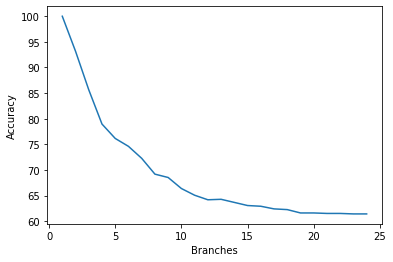

In [13]:
x = list(range(1,df.shape[0]+1))
y = df['Accuracy'].values

plt.xlabel("Branches")
plt.ylabel("Accuracy")
plt.plot(x,y)

#### Moving Average

In [35]:
averages = 10

total_error_counts = []
total_word_counts = []

total_average_decoder_times = []
total_average_backtrace_times = []

total_forward_computations = []

different_fs_word_table = [WFST_O]

for n in range(1, averages + 1):
    for idx, (f, word_table) in enumerate(different_fs_word_table[:]):
        f_error_counts = [0,0,0]
        f_word_counts = 0
        decoder_times = []
        backtrace_times = []
        forward_computations = []
        # -- Pruning -- Default False, False, None 
        pruning = [n,None,None]

        for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav')[:1]:    # replace path if using your own

            decoder = MyViterbiDecoder(f, wav_file, word_table)

            decoder_start_time = time.time()
            decoder.decode(pruning=pruning)
            decoder_end_time  = time.time()
            (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                               # to return the words along the best path
            backtrace_end_time = time.time()

            transcription = read_transcription(wav_file)
            error_counts = wer.compute_alignment_errors(transcription, words) #num_subs, num_del, num_ins
            word_count = len(transcription.split())

            # add up output
            f_word_counts += word_count
            f_error_counts[0] += error_counts[0]
            f_error_counts[1] += error_counts[1]
            f_error_counts[2] += error_counts[2]
    #         print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate

            # add up times
            decoder_time = decoder_end_time - decoder_start_time
            backtrace_time = backtrace_end_time - decoder_end_time

            decoder_times.append(decoder_time)
            backtrace_times.append(backtrace_time)

            # add up conputations
            forward_computations.append(decoder.forward_computations)

            # -- add to DataFrame
#             print(f"WFTS {idx}: Transcription: {transcription}\nWords: {words}")
        
    total_error_counts.append(f_error_counts)
    total_word_counts.append(f_word_counts)
    
    total_average_decoder_times.append(sum(decoder_times)/len(decoder_times))
    total_average_backtrace_times.append(sum(backtrace_times)/len(backtrace_times))
#     print(f"Forward computations for fst {idx}: {forward_computations}")
    total_forward_computations.append(sum(forward_computations)/len(forward_computations))

In [37]:
columns=['N Averages', 'S', 'D', 'I', 'Accuracy','Word Counts', 'Decoder Times', 'Backtrace Times', 'Forward Computations']
WFSTs = range(1,averages + 1)
total_error_counts = np.array(total_error_counts)
subs = total_error_counts[:,0]
deletions = total_error_counts[:,1]
insertions = total_error_counts[:,2]
accuracies = ((subs + deletions + insertions)/total_word_counts)*100
df = pd.DataFrame((WFSTs, subs, deletions, insertions, accuracies, total_word_counts, total_average_decoder_times, total_average_backtrace_times, total_forward_computations),index=columns).T
# df.to_excel('Pruning_branches.xlsx')

In [38]:
df.head(10)

,N Averages,S,D,I,Accuracy,Word Counts,Decoder Times,Backtrace Times,Forward Computations
0,1.0,4.0,2.0,0.0,85.714286,7.0,0.369920,0.000438,3376.0
1,2.0,0.0,7.0,0.0,100.000000,7.0,1.749055,0.000855,68900.0
2,3.0,0.0,7.0,0.0,100.000000,7.0,1.836667,0.000452,68690.0
3,4.0,0.0,7.0,0.0,100.000000,7.0,1.954034,0.000451,68480.0
4,5.0,0.0,7.0,0.0,100.000000,7.0,2.048860,0.000731,68270.0
5,6.0,0.0,7.0,0.0,100.000000,7.0,2.158566,0.000496,68060.0
6,7.0,0.0,7.0,0.0,100.000000,7.0,2.174804,0.000479,67850.0
7,8.0,0.0,7.0,0.0,100.000000,7.0,2.268159,0.000735,67640.0
8,9.0,0.0,7.0,0.0,100.000000,7.0,2.346009,0.000491,67430.0
9,10.0,0.0,7.0,0.0,100.000000,7.0,2.441619,0.000466,67220.0


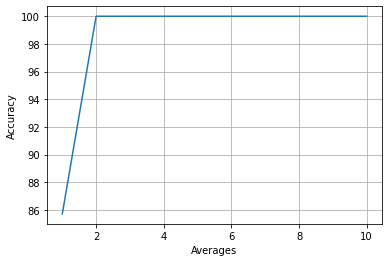

In [41]:
x = list(range(1,df.shape[0]+1))
y = df['Accuracy'].values

plt.xlabel("Averages")
plt.ylabel("Accuracy")
plt.plot(x,y)
plt.grid()
plt.show()

### Threshold

In [35]:
prob_thresholds = np.arange(0,1,0.1)
thresholds = -np.log(prob_thresholds)
# change threshold to NLL
thresholds[0] = MyViterbiDecoder.NLL_ZERO
thresholds

/afs/inf.ed.ac.uk/user/s16/s1645821/.conda/envs/asr_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


array([1.00000000e+10, 2.30258509e+00, 1.60943791e+00, 1.20397280e+00,
       9.16290732e-01, 6.93147181e-01, 5.10825624e-01, 3.56674944e-01,
       2.23143551e-01, 1.05360516e-01])

In [11]:
def run_task3(thresholds, prob_thresholds):
    total_error_counts = []
    total_word_counts = []

    total_average_decoder_times = []
    total_average_backtrace_times = []

    total_forward_computations = []

    different_fs_word_table = [WFST_BASELINE]

    for threshold in thresholds:
        for idx, (f, word_table) in enumerate(different_fs_word_table[:]):
            f_error_counts = [0,0,0]
            f_word_counts = 0
            decoder_times = []
            backtrace_times = []
            forward_computations = []
            # -- Pruning -- Default False, False, None 
            pruning = [None,None,threshold]

            for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav')[:]:    # replace path if using your own

                decoder = MyViterbiDecoder(f, wav_file, word_table)

                decoder_start_time = time.time()
                decoder.decode(pruning=pruning)
                decoder_end_time  = time.time()
                (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                                   # to return the words along the best path
                backtrace_end_time = time.time()

                transcription = read_transcription(wav_file)
                error_counts = wer.compute_alignment_errors(transcription, words) #num_subs, num_del, num_ins
                word_count = len(transcription.split())

                # add up output
                f_word_counts += word_count
                f_error_counts[0] += error_counts[0]
                f_error_counts[1] += error_counts[1]
                f_error_counts[2] += error_counts[2]
        #         print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate

                # add up times
                decoder_time = decoder_end_time - decoder_start_time
                backtrace_time = backtrace_end_time - decoder_end_time

                decoder_times.append(decoder_time)
                backtrace_times.append(backtrace_time)

                # add up conputations
                forward_computations.append(decoder.forward_computations)

                # -- add to DataFrame
    #             print(f"WFTS {idx}: Transcription: {transcription}\nWords: {words}")

        total_error_counts.append(f_error_counts)
        total_word_counts.append(f_word_counts)

        total_average_decoder_times.append(sum(decoder_times)/len(decoder_times))
        total_average_backtrace_times.append(sum(backtrace_times)/len(backtrace_times))
    #     print(f"Forward computations for fst {idx}: {forward_computations}")
        total_forward_computations.append(sum(forward_computations)/len(forward_computations))
    
    
    columns=['Threshold', 'S', 'D', 'I', 'Accuracy','Word Counts', 'Decoder Times', 'Backtrace Times', 'Forward Computations']
    WFSTs = prob_thresholds
    total_error_counts = np.array(total_error_counts)
    subs = total_error_counts[:,0]
    deletions = total_error_counts[:,1]
    insertions = total_error_counts[:,2]
    accuracies = ((subs + deletions + insertions)/total_word_counts)*100
    df = pd.DataFrame((WFSTs, subs, deletions, insertions, accuracies, total_word_counts, total_average_decoder_times, total_average_backtrace_times, total_forward_computations),index=columns).T
    return df

Test different thresholds because > 0.1 seems to be really bad

In [12]:
prob_thresholds = np.arange(0,1,0.1)
thresholds = -np.log(prob_thresholds)
# change threshold to NLL
thresholds[0] = MyViterbiDecoder.NLL_ZERO

df = run_task3(thresholds, prob_thresholds)
df.to_excel("data/prunning_threshold_sparse.xlsx")
df

/afs/inf.ed.ac.uk/user/s16/s1645821/.conda/envs/asr_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


,Threshold,S,D,I,Accuracy,Word Counts,Decoder Times,Backtrace Times,Forward Computations
0,0.0,441.0,60.0,813.0,61.430575,2139.0,2.255427,0.000759,77308.500000
1,0.1,0.0,2139.0,0.0,100.000000,2139.0,0.058268,0.000450,40.435714
2,0.2,0.0,2139.0,0.0,100.000000,2139.0,0.060967,0.000473,34.450000
3,0.3,0.0,2139.0,0.0,100.000000,2139.0,0.058078,0.000474,30.700000
4,0.4,0.0,2139.0,0.0,100.000000,2139.0,0.060141,0.000479,27.742857
5,0.5,0.0,2139.0,0.0,100.000000,2139.0,0.060166,0.000461,25.857143
6,0.6,0.0,2139.0,0.0,100.000000,2139.0,0.057900,0.000458,23.814286
7,0.7,0.0,2139.0,0.0,100.000000,2139.0,0.058013,0.000617,21.200000
8,0.8,0.0,2139.0,0.0,100.000000,2139.0,0.058153,0.000456,20.171429
9,0.9,0.0,2139.0,0.0,100.000000,2139.0,0.056493,0.000440,20.000000


In [13]:
end = 1e-24
prob_thresholds = np.ones(24)
print(prob_thresholds)
prob_thresholds[0] = 0
prob_thresholds = [x / (10**i) for i,x in enumerate(prob_thresholds)]
print(prob_thresholds)
thresholds = -np.log(prob_thresholds)
# change threshold to NLL
thresholds[0] = MyViterbiDecoder.NLL_ZERO

df= run_task3(thresholds, prob_thresholds)
df.to_excel("data/prunning_threshold_fine.xlsx")
df

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.0, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15, 1e-16, 1e-17, 1e-18, 1e-19, 1e-20, 1e-21, 1e-22, 1.0000000000000001e-23]


/afs/inf.ed.ac.uk/user/s16/s1645821/.conda/envs/asr_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


,Threshold,S,D,I,Accuracy,Word Counts,Decoder Times,Backtrace Times,Forward Computations
0,0.000000e+00,441.0,60.0,813.0,61.430575,2139.0,2.228936,0.000735,77308.500000
1,1.000000e-01,0.0,2139.0,0.0,100.000000,2139.0,0.060559,0.000476,40.435714
2,1.000000e-02,0.0,2139.0,0.0,100.000000,2139.0,0.060150,0.000465,58.878571
3,1.000000e-03,0.0,2139.0,0.0,100.000000,2139.0,0.060223,0.000487,77.907143
4,1.000000e-04,0.0,2139.0,0.0,100.000000,2139.0,0.062500,0.000459,104.521429
5,1.000000e-05,0.0,2139.0,0.0,100.000000,2139.0,0.063376,0.000497,131.807143
6,1.000000e-06,0.0,2139.0,0.0,100.000000,2139.0,0.064488,0.000471,152.892857
7,1.000000e-07,0.0,2139.0,0.0,100.000000,2139.0,0.062317,0.000460,174.807143
8,1.000000e-08,0.0,2139.0,0.0,100.000000,2139.0,0.064016,0.000455,200.307143
9,1.000000e-09,0.0,2139.0,0.0,100.000000,2139.0,0.065835,0.000465,224.935714


# Task 4

## Bigram WFST

In [24]:
# getting bigram probabbilities
(dict_first, dict_last, dict_all) = get_word_occurences(transcripts)
bigram_df = get_bigram_df(transcripts)
df_bigram_prob = get_bigram_prob_df(bigram_df, dict_all)

In [69]:
# getting the bigram fst
lex = 'lexicon.txt'
WFST_BIGRAM_F_5_5 = generate_word_sequence_recognition_wfst_bigram(1, lex, df_bigram_prob, original=False, weight_fwd=0.5, weight_self=0.5)
WFST_BIGRAM_F_3_7 = generate_word_sequence_recognition_wfst_bigram(1, lex, df_bigram_prob, original=False, weight_fwd=0.3, weight_self=0.7)


In [70]:
to_pic(WFST_BIGRAM_F_5_5[0],'WFST_BIGRAM')

## Setup for Running

In [71]:
total_error_counts = []
total_word_counts = []

total_average_decoder_times = []
total_average_backtrace_times = []

total_forward_computations = []
# -- lsit of wfst(s) from previous tasks
list_wfst_task1 = [WFST_1_9_O, WFST_1_9, WFST_O, WFST_multi]
list_wfst_task2 = [WFST_silent, WFST_unigram, WFST_3_7, WFST_final_prob]
list_wfst_task4 = [WFST_BIGRAM_F_5_5, WFST_BIGRAM_F_3_7] 
# -- wfst(s) used
# different_fs_word_table = list_wfst_task4 + list_wfst_task2 + list_wfst_task1
different_fs_word_table = [WFST_BIGRAM_F_5_5]

## Running WFST

In [ ]:
for idx, (f, word_table) in enumerate(different_fs_word_table[:]):
    f_error_counts = [0,0,0]
    f_word_counts = 0
    decoder_times = []
    backtrace_times = []
    forward_computations = []
    # -- Pruning -- Default False, False, None 
    pruning = [None,None,None]
    
    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav')[:]:    # replace path if using your own
        
        decoder = MyViterbiDecoder(f, wav_file, word_table)
        
        decoder_start_time = time.time()
        decoder.decode(pruning=pruning)
        decoder_end_time  = time.time()
        (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                           # to return the words along the best path
        backtrace_end_time = time.time()
        
        transcription = read_transcription(wav_file)
        error_counts = wer.compute_alignment_errors(transcription, words) #num_subs, num_del, num_ins
        word_count = len(transcription.split())
        
        # add up output
        f_word_counts += word_count
        f_error_counts[0] += error_counts[0]
        f_error_counts[1] += error_counts[1]
        f_error_counts[2] += error_counts[2]
#         print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate
        
        # add up times
        decoder_time = decoder_end_time - decoder_start_time
        backtrace_time = backtrace_end_time - decoder_end_time
        
        decoder_times.append(decoder_time)
        backtrace_times.append(backtrace_time)
        
        # add up conputations
        forward_computations.append(decoder.forward_computations)
        
        # -- add to DataFrame
#         print(f"WFTS {idx}: Transcription: {transcription}\nWords: {words}")
        
    total_error_counts.append(f_error_counts)
    total_word_counts.append(f_word_counts)
    
    total_average_decoder_times.append(sum(decoder_times)/len(decoder_times))
    total_average_backtrace_times.append(sum(backtrace_times)/len(backtrace_times))
#     print(f"Forward computations for fst {idx}: {forward_computations}")
    total_forward_computations.append(sum(forward_computations)/len(forward_computations))


doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
d

doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
d

doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
doing regular step forward
d

## Results

In [73]:
# list_wfst_task1 = [WFST_1_9_O, WFST_1_9, WFST_O, WFST_multi]
# list_wfst_task2 = [WFST_silent, WFST_unigram, WFST_3_7, WFST_final_prob]
# list_wfst_task4 = [WFST_BIGRAM_F_5_5, WFST_BIGRAM_F_3_7] 

In [77]:
columns=['WFST', 'S', 'D', 'I', 'Accuracy','Word Counts', 'Decoder Times', 'Backtrace Times', 'Forward Computations']
# WFSTs = ['WFST_BIGRAM_F_5_5', 'WFST_BIGRAM_F_3_7', 'WFST_silent','WFST_unigram', 'WFST_3_7', 'WFST_final_prob', 'WFST_1_9_O', 'WFST_1_9', 'WFST_O', 'WFST_multi']
WFSTs = ['WFST_BIGRAM_F_5_5'] 
total_error_counts = np.array(total_error_counts)
subs = total_error_counts[:,0]
deletions = total_error_counts[:,1]
insertions = total_error_counts[:,2]
accuracies = ((subs + deletions + insertions)/total_word_counts)*100
df = pd.DataFrame((WFSTs, subs, deletions, insertions, accuracies, total_word_counts, total_average_decoder_times, total_average_backtrace_times, total_forward_computations),index=columns).T
# df.to_excel('task4_bigram.xlsx')

In [75]:
df

,WFST,S,D,I,Accuracy,Word Counts,Decoder Times,Backtrace Times,Forward Computations
0,WFST_BIGRAM_F_5_5,451,2,3092,165.73165,2139,1.366138,0.000852,27868.314286


### Tree Lexicon

In [11]:
trie = Trie('lexicon_tree_baseline.txt')
trie_wfst = trie.f
trie_word_table = trie.word_table

trie_wfst_word_table = (trie_wfst,trie_word_table )

In [16]:
WFSTs_word_table = [trie_wfst_word_table]

total_error_counts = []
total_word_counts = []

total_average_decoder_times = []
total_average_backtrace_times = []

total_forward_computations = []

for f, word_table in WFSTs_word_table[:]:
    f_error_counts = [0,0,0]
    f_word_counts = 0
    decoder_times = []
    backtrace_times = []
    forward_computations = []    
    
    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav')[:]:    # replace path if using your own
        
        decoder = MyViterbiDecoder(f, wav_file, word_table)
        
        decoder_start_time = time.time()
        decoder.decode()
        decoder_end_time  = time.time()
        (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                           # to return the words along the best path
        backtrace_end_time = time.time()
        
        transcription = read_transcription(wav_file)
        
        # remove silence from words as this doesnt count in transcription
#         if ('<silence>' in words):
#             words = words.replace('<silence>', '')
#             words = words[1:-1]
        
        error_counts = wer.compute_alignment_errors(transcription, words) #num_subs, num_del, num_ins
        word_count = len(transcription.split())
        
#         print(f"Transcription: {transcription}\nWords: {words}")
        
        # add up output
        f_word_counts += word_count
        f_error_counts[0] += error_counts[0]
        f_error_counts[1] += error_counts[1]
        f_error_counts[2] += error_counts[2]
#         print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate
        
        # add up times
        decoder_time = decoder_end_time - decoder_start_time
        backtrace_time = backtrace_end_time - decoder_end_time
        
        decoder_times.append(decoder_time)
        backtrace_times.append(backtrace_time)
        
        # add up conputations
        forward_computations.append(decoder.forward_computations)
        
        # -- add to DataFrame
#         wav_name = wav_file.split('\\')[-1]
#         pd_row = []
        
    total_error_counts.append(f_error_counts)
    total_word_counts.append(f_word_counts)
    
    total_average_decoder_times.append(sum(decoder_times)/len(decoder_times))
    total_average_backtrace_times.append(sum(backtrace_times)/len(backtrace_times))
    
    total_forward_computations.append(sum(forward_computations)/len(forward_computations))

In [17]:
columns=['WFST', 'S', 'D', 'I', 'Accuracy','Word Counts', 'Decoder Times', 'Backtrace Times', 'Forward Computations']
WFSTs = ['Tree baseline']
total_error_counts = np.array(total_error_counts)
subs = total_error_counts[:,0]
deletions = total_error_counts[:,1]
insertions = total_error_counts[:,2]
accuracies = ((subs + deletions + insertions)/total_word_counts)*100
df = pd.DataFrame((WFSTs, subs, deletions, insertions, accuracies, total_word_counts, total_average_decoder_times, total_average_backtrace_times, total_forward_computations),index=columns).T
df.to_excel('task4_tree_baseline.xlsx')
df

,WFST,S,D,I,Accuracy,Word Counts,Decoder Times,Backtrace Times,Forward Computations
0,Tree baseline,441,60,813,61.430575,2139,2.10464,0.000769,58575.985714


# OTHER